# Fase 1: Preparación del conjunto de datos 

## Estructura de los datos(Imágenes Nibabel)<a name="id1"></a>


Un objeto de imagen nibabel es la asociación de tres cosas:


*   una matriz N-D que contiene los datos de la imagen;
*   una matriz de mapeo de matriz afín (4, 4) de coordenadas a coordenadas en algún espacio de coordenadas mundial RAS+ ([sistemas de coordenadas y afines](https://nipy.org/nibabel/coordinate_systems.html ));
*   metadatos de imagen en forma de encabezado.





## El objeto de la imagen
Primero cargamos algunas bibliotecas que necesitaremos para los ejemplos:

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, UpSampling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io as io
from glob import glob

import numpy as np
import random as r
import cv2


In [3]:
import numpy as np
import os
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [4]:
example_file = os.path.join( 'GLIOMA/BraTS-GLI-00005-100/BraTS-GLI-00005-100-seg.nii.gz')
img = nib.load(example_file)
img

El objeto img es una instancia de una imagen de nibabel. De hecho, es una instancia de nibabel nibabel.nifti1.Nifti1Image:

In [52]:
TRAIN_DATASET_PATH = 'GLIOMA/'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00005-100/BraTS-GLI-00005-100-t2f.nii.gz').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00005-100/BraTS-GLI-00005-100-t1n.nii.gz').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00005-100/BraTS-GLI-00005-100-t1c.nii.gz').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00005-100/BraTS-GLI-00005-100-t2w.nii.gz').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00005-100/BraTS-GLI-00005-100-seg.nii.gz').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)


1406.898681640625
[0 2 4]


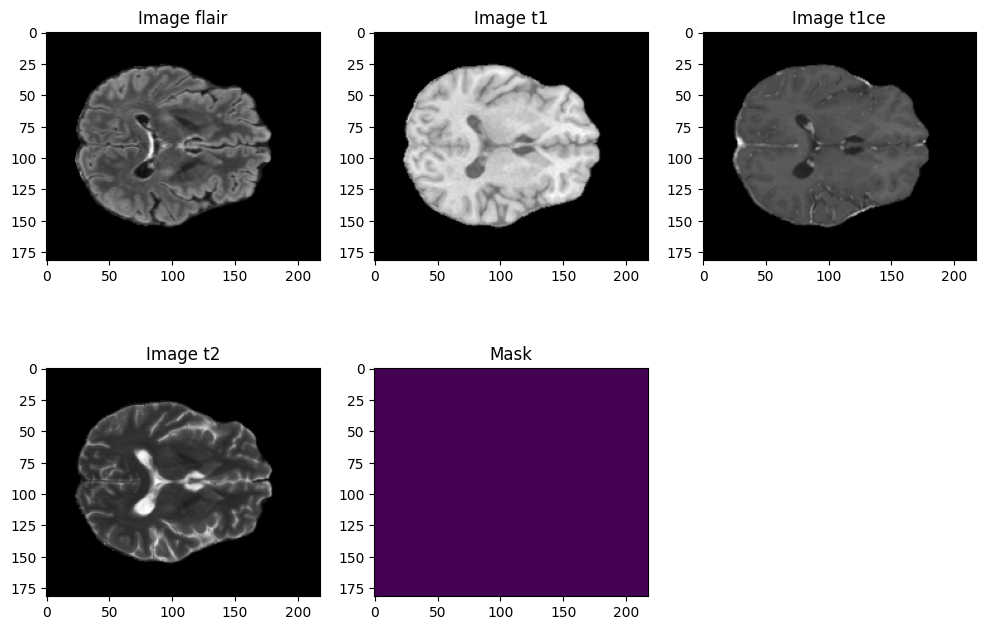

In [53]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [54]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
# Asegúrate de que las dimensiones son correctas antes de recortar
print(f"Dimensiones antes de recortar: {combined_x.shape}")

# Verifica las dimensiones originales
H, W, D, C = combined_x.shape

# Determina el recorte para que todas las dimensiones sean 128
if H >= 128 and W >= 128 and D >= 128:
    # Calcula el inicio y fin del recorte para cada dimensión
    start_h = (H - 128) // 2
    start_w = (W - 128) // 2
    start_d = (D - 128) // 2
    
    combined_x = combined_x[start_h:start_h + 128, start_w:start_w + 128, start_d:start_d + 128]
else:
    raise ValueError("Las dimensiones de entrada son menores a 128, no se puede recortar a 128x128x128")

# Verifica las dimensiones después de recortar
print(f"Dimensiones después de recortar: {combined_x.shape}")

Dimensiones antes de recortar: (182, 218, 182, 3)
Dimensiones después de recortar: (128, 128, 128, 3)


In [55]:
#Do the same for mask
test_mask = test_mask[27:155, 45:173, 27:155]
print(test_mask.shape)  # Debería imprimir (128, 128, 128, 3)

(128, 128, 128)


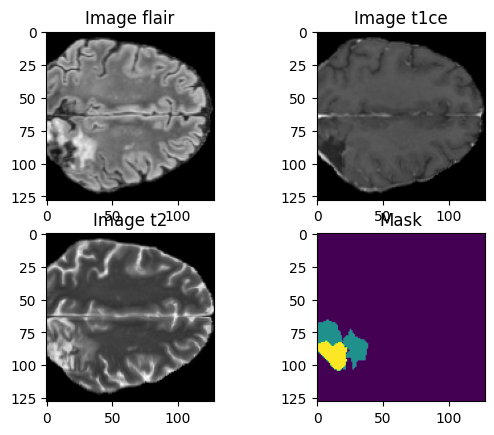

In [58]:
plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [14]:
import os
os.makedirs('input_data_3channels/images')
os.makedirs('input_data_3channels/masks')

In [4]:
t2_list = sorted(glob.glob('GLIOMA/*/*t2w.nii.gz'))
t1ce_list = sorted(glob.glob('GLIOMA/*/*t1c.nii.gz'))
flair_list = sorted(glob.glob('GLIOMA/*/*t2f.nii.gz'))
mask_list = sorted(glob.glob('GLIOMA/*/*seg.nii.gz'))

In [5]:

for img in range(len(t2_list)):   # Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    # Obtener las dimensiones originales
    H, W, D, C = temp_combined_images.shape
    
    # Calcular el recorte centrado para obtener 128x128x128
    if H >= 128 and W >= 128 and D >= 128:
        start_h = (H - 128) // 2
        start_w = (W - 128) // 2
        start_d = (D - 128) // 2
        
        temp_combined_images = temp_combined_images[start_h:start_h + 128, start_w:start_w + 128, start_d:start_d + 128]
        temp_mask = temp_mask[start_h:start_h + 128, start_w:start_w + 128, start_d:start_d + 128]
    else:
        raise ValueError("Las dimensiones de entrada son menores a 128, no se puede recortar a 128x128x128")
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0] / counts.sum())) > 0.01:  # At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask = to_categorical(temp_mask, num_classes=5)
        np.save('input_data_3channels/images/image_' + str(img) + '.npy', temp_combined_images)
        np.save('input_data_3channels/masks/mask_' + str(img) + '.npy', temp_mask)
    else:
        print("I am useless")


Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
I am useless
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
I am useless
Now preparing image and masks number:  6
I am useless
Now preparing image and masks number:  7
I am useless
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks numbe

Dimensiones de la imagen 0: (128, 128, 128, 3)
Dimensiones de la máscara 0: (128, 128, 128, 5)
Clases en la máscara 0: [0 2 4]
Conteo de píxeles por clase en la máscara 0: [2072195   20755    4202]


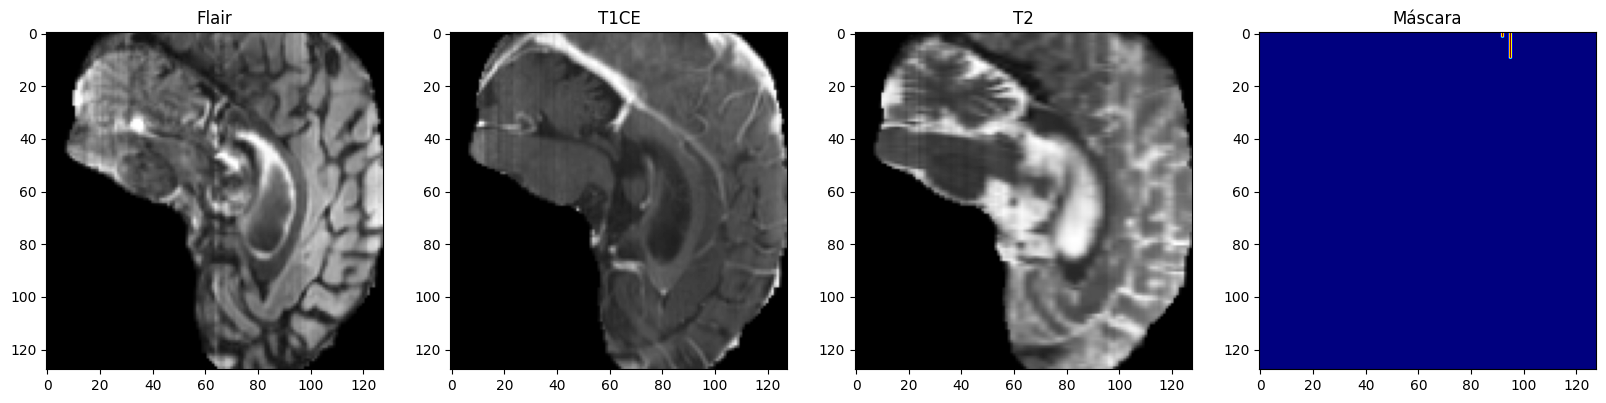

Dimensiones de la imagen 1: (128, 128, 128, 3)
Dimensiones de la máscara 1: (128, 128, 128, 5)
Clases en la máscara 1: [0 2 4]
Conteo de píxeles por clase en la máscara 1: [2071778   21761    3613]


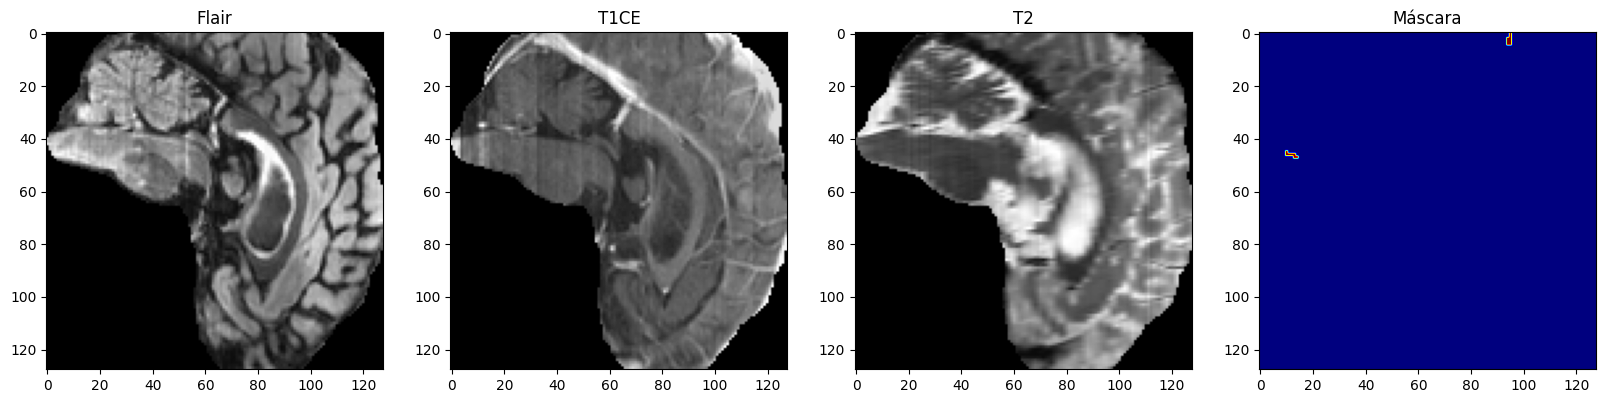

Dimensiones de la imagen 2: (128, 128, 128, 3)
Dimensiones de la máscara 2: (128, 128, 128, 5)
Clases en la máscara 2: [0 1 2 3 4]
Conteo de píxeles por clase en la máscara 2: [1997932    1400   83791   13328     701]


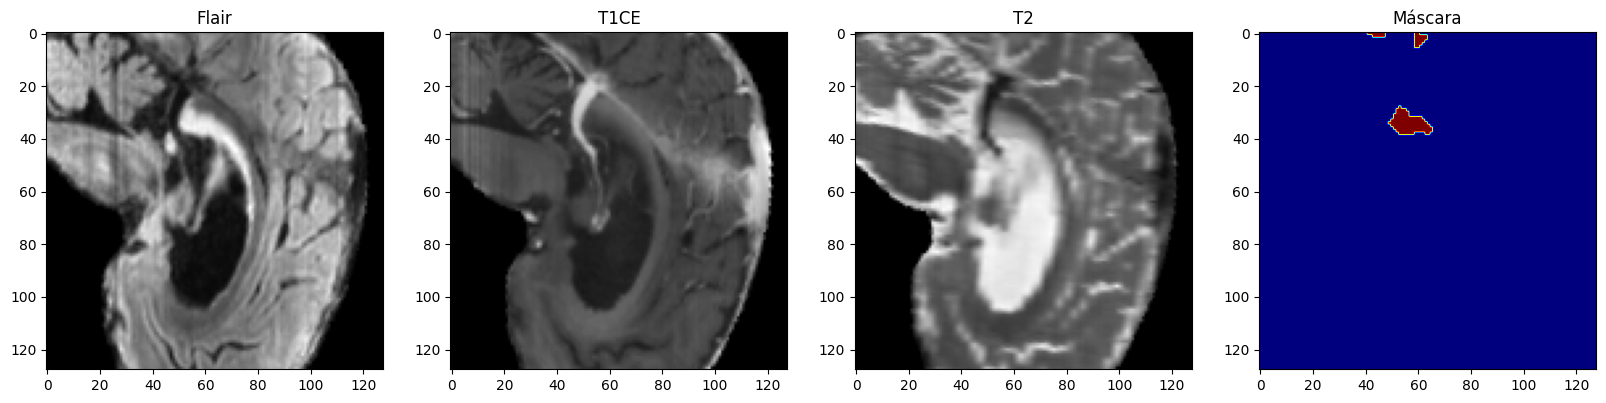

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Directorios de las imágenes y máscaras procesadas
images_dir = 'input_data_3channels/images/'
masks_dir = 'input_data_3channels/masks/'

# Listar archivos
image_files = sorted(glob.glob(images_dir + '*.npy'))
mask_files = sorted(glob.glob(masks_dir + '*.npy'))

# Comprobar dimensiones y estadísticas
for i in range(3):  # Verificar las primeras 3 imágenes y máscaras
    img = np.load(image_files[i])
    mask = np.load(mask_files[i])

    # Comprobar dimensiones
    print(f"Dimensiones de la imagen {i}: {img.shape}")
    print(f"Dimensiones de la máscara {i}: {mask.shape}")

    # Comprobar estadísticas
    mask_classes, mask_counts = np.unique(np.argmax(mask, axis=-1), return_counts=True)
    print(f"Clases en la máscara {i}: {mask_classes}")
    print(f"Conteo de píxeles por clase en la máscara {i}: {mask_counts}")

    # Visualización
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    ax[0].imshow(img[64, :, :, 0], cmap='gray')  # Canal Flair
    ax[0].set_title('Flair')

    ax[1].imshow(img[64, :, :, 1], cmap='gray')  # Canal T1CE
    ax[1].set_title('T1CE')

    ax[2].imshow(img[64, :, :, 2], cmap='gray')  # Canal T2
    ax[2].set_title('T2')

    ax[3].imshow(np.argmax(mask[64, :, :, :], axis=-1), cmap='jet')  # Máscara
    ax[3].set_title('Máscara')

    plt.show()


In [7]:
#Repeat the same from above for validation data folder OR
#Split training data into train and validation

"""
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 

pip install split-folders
"""
import splitfolders  # or import split_folders

input_folder = 'input_data_3channels/'
output_folder = 'input_data_128/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

In [63]:
import os
import numpy as np
from custom_datagen import imageLoader
#import tensorflow as tf
from matplotlib import pyplot as plt
import glob
import random


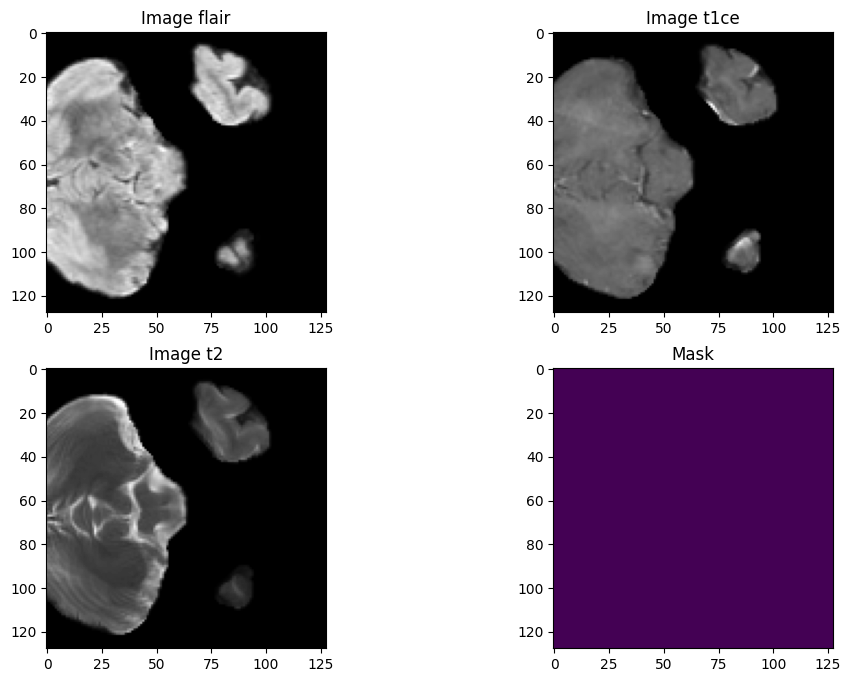

In [64]:
train_img_dir = "input_data_128/train/images/"
train_mask_dir = "input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [65]:
train_img_dir = "input_data_128/train/images/"
train_mask_dir = "input_data_128/train/masks/"

val_img_dir = "input_data_128/val/images/"
val_mask_dir = "input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

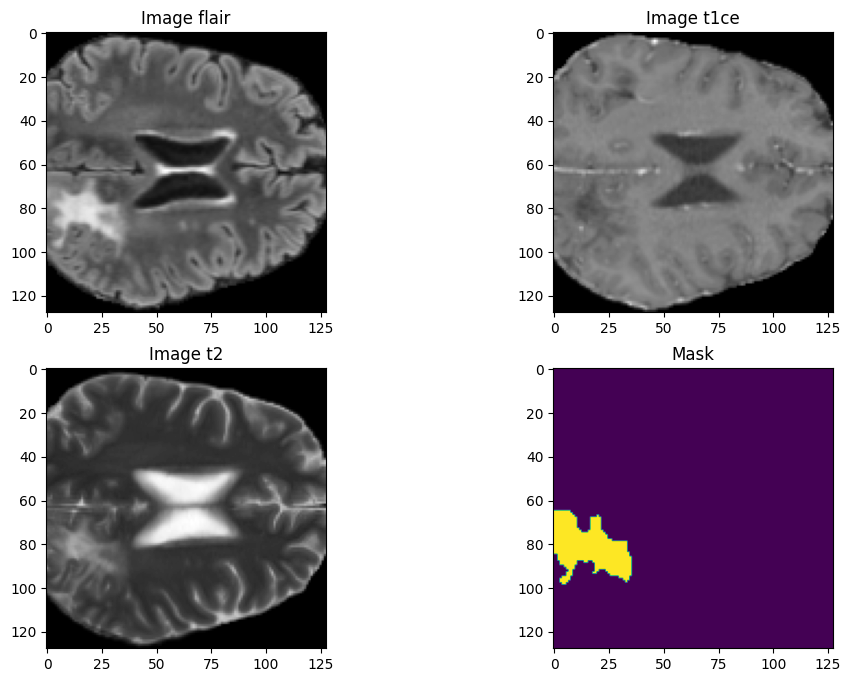

In [73]:
batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [74]:
# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def hausdorff_distance(y_true, y_pred):
    # Flatten y_true and y_pred
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)

    # Find indices where y_true and y_pred are non-zero
    indices_true = tf.where(K.not_equal(y_true_flat, 0))
    indices_pred = tf.where(K.not_equal(y_pred_flat, 0))

    # Extract coordinates
    points_true = K.cast(indices_true, 'float32')
    points_pred = K.cast(indices_pred, 'float32')

    # Calculate pairwise distances
    dist_matrix = K.sqrt(K.sum(K.square(tf.expand_dims(points_true, 1) - tf.expand_dims(points_pred, 0)), axis=-1))

    # Calculate Hausdorff distance
    hausdorff_dist = K.max(K.min(dist_matrix, axis=1), axis=0)

    return hausdorff_dist

In [75]:
def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    


In [76]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [108]:
def UNet(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

  # Downsampling
  c1 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(inputs)
  c1 = Dropout(0.1)(c1)
  c1 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
  p1 = MaxPooling3D((2, 2, 2))(c1)

  c2 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
  p2 = MaxPooling3D((2, 2, 2))(c2)

  c3 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
  p3 = MaxPooling3D((2, 2, 2))(c3)

  c4 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
  p4 = MaxPooling3D((2, 2, 2))(c4)

  c5 = Conv3D(filters = 256, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv3D(filters = 256, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

  # Upsampling part
  u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv3D(filters = 128, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

  u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv3D(filters = 64, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

  u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv3D(filters = 32, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

  u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1])
  c9 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv3D(filters = 16, kernel_size = 3, strides = 1, activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

  outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  model.summary()

  return model

In [111]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = UNet(IMG_HEIGHT = 128,
              IMG_WIDTH = 128,
              IMG_DEPTH = 128,
              IMG_CHANNELS = 3,
              num_classes = 5)

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy', MeanIoU(num_classes=5), dice_coef, precision, sensitivity, specificity])


print(model.summary)

print(model.input_shape)
print(model.output_shape)

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_458 (Conv3D)             (None, 128, 128, 128 1312        input_29[0][0]                   
__________________________________________________________________________________________________
dropout_220 (Dropout)           (None, 128, 128, 128 0           conv3d_458[0][0]                 
__________________________________________________________________________________________________
conv3d_459 (Conv3D)             (None, 128, 128, 128 6928        dropout_220[0][0]                
___________________________________________________________________________________________

In [112]:
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch
                    )

Epoch 1/100
   3/1075 [..............................] - ETA: 13:38 - loss: 1.6800 - accuracy: 0.2065 - mean_io_u_21: 0.4000 - dice_coef: 0.1890 - precision: 0.1111 - sensitivity: 5.2982e-08 - specificity: 1.0000    

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  ConcatOp : Dimensions of inputs should match: shape[0] = [1,14,16,16,128] vs. shape[1] = [1,15,16,16,128]
	 [[node model_23/concatenate_96/concat (defined at \AppData\Local\Temp\ipykernel_20972\3694315593.py:1) ]]
	 [[confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/branch_executed/_17/_75]]
  (1) Invalid argument:  ConcatOp : Dimensions of inputs should match: shape[0] = [1,14,16,16,128] vs. shape[1] = [1,15,16,16,128]
	 [[node model_23/concatenate_96/concat (defined at \AppData\Local\Temp\ipykernel_20972\3694315593.py:1) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_69249]

Function call stack:
train_function -> train_function
